# dataset

> This module contains the dataset of the soundscapes and a function to retrieve it.

In [ ]:
#| default_exp dataset

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.utils import *

In [ ]:
#| export
from IPython.display import Audio
import pandas as pd
from sklearn.preprocessing import LabelBinarizer

import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random

from birdclef.utils import DATA_DIR, AUDIO_DATA_DIR, mel_to_wave, plot_audio, plot_spectrogram, plot_librosa

## Pytorch dataset of soundscapes

### Extraction pipeline

Cose che abbiamo provato:
- power 2.0 e visto che funziona meglio con un power più alto

In [ ]:
#| export
# Define custom feature extraction pipeline.
# 0. a randomn offset is applied to the audio file, so not always the same part of the audio is used
# 1. Check for sample rate and resample
# 2. Waveform Augmenations
# 3. Convert to mel-scale
# 4. Mel Augmenations
# 5. Check for lenght and stretch shorter videos




    
    
class MyPipeline(torch.nn.Module):
    def __init__(
        self,
        seconds = 5,
        sample_rate=32000,
        f_min = 50,
        f_max = 16000,
        n_fft=2048,
        n_mels=128,
        hop_length = 1024,
        power = 8.0,
        per_channel = False,
        augmentations = False,
        rnd_offset = False,
    ):
        super().__init__()

        self.augmentations = augmentations
        self.n_fft = n_fft
        self.seconds = seconds
        self.c_length = seconds * sample_rate // hop_length + 1
        # self.c_length = c_length * 62.6 #626 sono 10 secondi
        self.sample_rate = sample_rate
        self.hop_length = hop_length
        self.per_channel = per_channel
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=self.sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, f_min=f_min, f_max=f_max, power=power)
        self.amptodb = torchaudio.transforms.AmplitudeToDB()
        self.stretch = torchaudio.transforms.TimeStretch(hop_length=hop_length, n_freq=128)
        

        #Augmentations
        self.maskingFreq =  torchaudio.transforms.FrequencyMasking(freq_mask_param=40)
        # self.maskingTime = torchaudio.transforms.TimeMasking(time_mask_param=20)
        self.noiser = torchaudio.transforms.AddNoise()
        
        self.rnd_offset = rnd_offset


    def forward(self, filename):
        # 0 Load the File
        if self.rnd_offset:
            metadata = torchaudio.info(filename)
            if metadata.num_frames - self.seconds * self.sample_rate > 0:
                rnd_offset = np.random.randint(0, metadata.num_frames - self.seconds*self.sample_rate)
            else:
                # Handle the case where metadata.num_frames <= self.seconds*self.sample_rate
                # For example, you can set rnd_offset to a default value:
                rnd_offset = 0
            waveform, rate = torchaudio.load(filename, frame_offset=rnd_offset, num_frames=self.seconds*self.sample_rate)
        else: 
            waveform, rate = torchaudio.load(filename, frame_offset=0, num_frames=self.seconds*self.sample_rate)
        
        # 1 Check for the sample rate and eventually resample to 32k
        if rate != self.sample_rate:
            print("Wrong sample rate: resampling audio")
            resampler = torchaudio.transforms.Resample(orig_freq=rate, new_freq=self.sample_rate)
            waveform = resampler(waveform)
            
        
        # 2 Waveform Augmenations
        if self.augmentations:
            #  Rasdom noise
            if np.random.random() > 0.5:
                noise = torch.randn_like(waveform) 
                snr_dbs = torch.tensor([10])
                waveform = self.noiser(waveform, noise, snr_dbs)               
        

        # 3 Convert to mel-scale
        mel = self.melspec(waveform)
        
        # 4 Mel Augmenations
        if self.augmentations:
            # if np.random.random() > 0.8:
            #     mel = self.maskingTime(mel)
                
            if np.random.random() > 0.5:
                mel = self.maskingFreq(mel)
                
        
        if not self.per_channel:
            mel = self.amptodb(mel)

        else:
            melspec_np = mel.detach().cpu().numpy()
            mel_pcen =librosa.pcen(melspec_np * (2 ** 31), sr=self.sample_rate, hop_length=self.hop_length)
            mel = torch.from_numpy(mel_pcen).float()
            
            

        # 4 Check for the length and stretch it to 10s, it is a transformation used to regularize the length of the data
        if mel.shape[2] < self.c_length:
            # print("Audio too short: stretching it.")
            replay_rate =  mel.shape[2]/self.c_length
            #print(f"replay rate {replay_rate}%")
            mel = self.stretch(mel, replay_rate).real
            mel = mel[:,:,0:self.c_length]
            #print(f"stretched shape {stretched.shape}")
            
        # 5 Check for the length and reduce it to 10s, it is a transformation used to regularize the length of the data
        if mel.shape[2] > self.c_length:
            # print("Audio too long: reducing it.")
            replay_rate =  mel.shape[2]/self.c_length
            #print(f"replay rate {replay_rate}%")
            mel = self.stretch(mel, 1/replay_rate).real
            mel = mel[:,:,0:self.c_length]
            #print(f"stretched shape {stretched.shape}")

        return mel
    
    def inverse_transform(self, mel):
        n_stft = self.n_fft // 2 + 1
        mel = mel.cpu()
        mel = mel[:,:,0:self.c_length]
        print(mel.shape)
        invers_transform = torchaudio.transforms.InverseMelScale(sample_rate=self.sample_rate, n_stft=n_stft)
        grifflim_transform = torchaudio.transforms.GriffinLim(n_fft=self.n_fft)

        mel = torch.pow(10, mel/10)
        inverse_waveform = invers_transform(mel)
        pseudo_waveform = grifflim_transform(inverse_waveform)

        return pseudo_waveform

### Checking the pipeline and the augmentations

I'm having issues with non matching tensor sizes, I want to find out why. 

In [ ]:
# Get a list of all files in the directory
filenames = os.listdir(AUDIO_DATA_DIR + 'afghor1/')
pipeline = MyPipeline(per_channel=True, augmentations=True, rnd_offset=True)
# Apply the pipeline to each file
for filename in filenames:
    if filename.endswith('.ogg'):
        mel_spec = pipeline(AUDIO_DATA_DIR + 'afghor1/' + filename)
        # plot_spectrogram(mel_spec[0], title='Mel spectrogram', db=True)
        print(f"size of mel_spec {filename } {mel_spec.shape}")

size of mel_spec XC156639.ogg torch.Size([1, 128, 157])
size of mel_spec XC169690.ogg torch.Size([1, 128, 157])
size of mel_spec XC174843.ogg torch.Size([1, 128, 157])
size of mel_spec XC194520.ogg torch.Size([1, 128, 157])
size of mel_spec XC196514.ogg torch.Size([1, 128, 157])
size of mel_spec XC200577.ogg torch.Size([1, 128, 157])
size of mel_spec XC200734.ogg torch.Size([1, 128, 157])
size of mel_spec XC215421.ogg torch.Size([1, 128, 157])
size of mel_spec XC215422.ogg torch.Size([1, 128, 157])
size of mel_spec XC239842.ogg torch.Size([1, 128, 157])
size of mel_spec XC246634.ogg torch.Size([1, 128, 157])
size of mel_spec XC283019.ogg torch.Size([1, 128, 157])
size of mel_spec XC289284.ogg torch.Size([1, 128, 157])
size of mel_spec XC292595.ogg torch.Size([1, 128, 157])
size of mel_spec XC294658.ogg torch.Size([1, 128, 157])
size of mel_spec XC297425.ogg torch.Size([1, 128, 157])
size of mel_spec XC315438.ogg torch.Size([1, 128, 157])
size of mel_spec XC315563.ogg torch.Size([1, 128

### Testing noisy audio


Original audio


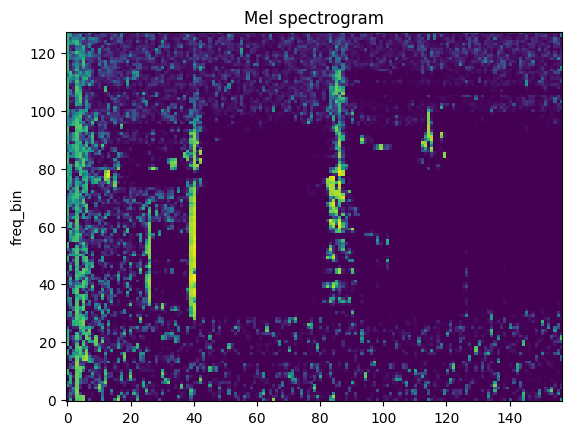

In [ ]:
filename = '../data/audio_data/thrnig1/XC193336.ogg'
print('Original audio')
display(Audio(filename, rate=32000))
pipeline = MyPipeline(per_channel=True, augmentations=True)
mel_spec = pipeline(filename)
type(mel_spec)
mel_spec.shape
plot_spectrogram(mel_spec[0], title='Mel spectrogram', db=True)
# waveform = mel_to_wave(mel_spec)
# plot_audio(waveform=waveform, sample_rate=32000)
#print('Filtered audio')
#display(Audio(filtered.numpy(), rate=32000))
# print('Reconstructed audio')
# display(Audio(waveform.numpy(), rate=32000))


### Pytorch dataset

In [ ]:
#| export
class BirdClef(Dataset):

    def __init__(self, metadata=None, classes=None, per_channel=False, augmentations=False, rnd_offset=False):
        
    

        self.metadata = metadata
        sorted_classes = classes.sort_values()
        self.classes = sorted_classes
        self.per_channel = per_channel
        self.augmentations = augmentations
        self.rnd_offset = rnd_offset

        self.length = len(self.metadata)

        binarizer = LabelBinarizer()
        binarizer.fit(self.classes)

        self.labels = binarizer.transform(metadata.primary_label)
        
        self.num_classes = self.labels.shape[1]

        self.labels = torch.from_numpy(self.labels).float()
        
        _, self.labels = torch.max(self.labels, dim=1)
        
        # Initialize a pipeline
        self.pipeline = MyPipeline(per_channel = self.per_channel, augmentations = self.augmentations, rnd_offset = self.rnd_offset)
    
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        filename = AUDIO_DATA_DIR + self.metadata['filename'][idx]
        mel_spectrogram = self.pipeline(filename)

        label = self.labels[idx].long()
        
        return {'input': mel_spectrogram, 'label': label, 'filename': filename}

In [ ]:

train = pd.read_csv(DATA_DIR + 'base/train_metadata.csv')
ds_test = BirdClef(train, train.primary_label, per_channel=True, augmentations=True, rnd_offset=True)
print(ds_test.classes)
print(len(ds_test.labels.shape))
print(ds_test.num_classes)

0       chibat1
1       combuz1
2       tafpri1
3        barswa
4        grecor
         ...   
9898    eaywag1
9899    gnbcam2
9900    scthon1
9901     categr
9902     greegr
Name: primary_label, Length: 9903, dtype: object
1
261


In [ ]:
train = pd.read_csv(DATA_DIR + 'base/train_metadata.csv')
ds_test = BirdClef(train, train.primary_label, per_channel=True, augmentations=True, rnd_offset=True)
print(f'The dataset has length {len(ds_test)}')
print(f'This is an example from the dataset:\n{ds_test.__getitem__(0)}')

The dataset has length 9903


LibsndfileError: Error opening '../data/audio_data/chibat1/XC675569.ogg': System error.

## Handling datasets and dataloaders

After creating the `BirdClef` dataset it is possible to handle the different versions (*train, val, test...*) of the dataset using a dictionary and a getter function. Since pytorch trains models using dataloaders we also need to create a method to retrieve them.

In [ ]:
#| export
dir = DATA_DIR
try:
    train_metadata_base = pd.read_csv(dir + 'base/train_metadata.csv')
    val_metadata_base = pd.read_csv(dir + 'base/val_metadata.csv')
    test_metadata_base = pd.read_csv(dir + 'base/test_metadata.csv')
except FileNotFoundError:
    dir = 'data/'
    train_metadata_base = pd.read_csv(dir + 'base/train_metadata.csv')
    val_metadata_base = pd.read_csv(dir + 'base/val_metadata.csv')
    test_metadata_base = pd.read_csv(dir + 'base/test_metadata.csv')

simple_classes = ['thrnig1', 'wlwwar', 'barswa']
train_metadata_simple = train_metadata_base.loc[train_metadata_base.primary_label.isin(simple_classes)].reset_index()
val_metadata_simple = val_metadata_base.loc[val_metadata_base.primary_label.isin(simple_classes)].reset_index()
test_metadata_simple = test_metadata_base.loc[test_metadata_base.primary_label.isin(simple_classes)].reset_index()

Creating also repeated dataset

In [ ]:
#| export
dir = DATA_DIR
try:
    train_metadata_repeated = pd.read_csv(dir + 'repeated/train_metadata.csv')
    val_metadata_repeated = pd.read_csv(dir + 'repeated/val_metadata.csv')
    test_metadata_repeated = pd.read_csv(dir + 'repeated/test_metadata.csv')
except FileNotFoundError:
    dir = 'data/'
    train_metadata_repeated = pd.read_csv(dir + 'repeated/train_metadata.csv')
    val_metadata_repeated = pd.read_csv(dir + 'repeated/val_metadata.csv')
    test_metadata_repeated = pd.read_csv(dir + 'repeated/test_metadata.csv')

In [ ]:
#| export
dataset_dict = {
            'train_base': (BirdClef, {'metadata': train_metadata_base, 'classes': train_metadata_base.primary_label}),
            'val_base': (BirdClef, {'metadata': val_metadata_base, 'classes': train_metadata_base.primary_label}),
            'test_base': (BirdClef, {'metadata': test_metadata_base, 'classes': train_metadata_base.primary_label}),

            'train_simple': (BirdClef, {'metadata': train_metadata_simple, 'classes': train_metadata_simple.primary_label}),
            'val_simple': (BirdClef, {'metadata': val_metadata_simple, 'classes': train_metadata_simple.primary_label}),
            'test_simple': (BirdClef, {'metadata': test_metadata_simple, 'classes': train_metadata_simple.primary_label}),
            
            'train_simple_per_channel': (BirdClef, {'metadata': train_metadata_simple, 'classes': train_metadata_simple.primary_label, 'per_channel': True}),
            'val_simple_per_channel': (BirdClef, {'metadata': val_metadata_simple, 'classes': train_metadata_simple.primary_label, 'per_channel': True}),
            'test_simple_per_channel': (BirdClef, {'metadata': test_metadata_simple, 'classes': train_metadata_simple.primary_label, 'per_channel': True}),
            
            'train_base_per_channel': (BirdClef, {'metadata': train_metadata_base, 'classes': train_metadata_base.primary_label, 'per_channel': True}),
            'val_base_per_channel': (BirdClef, {'metadata': val_metadata_base, 'classes': train_metadata_base.primary_label, 'per_channel': True}),
            'test_base_per_channel': (BirdClef, {'metadata': test_metadata_base, 'classes': train_metadata_base.primary_label, 'per_channel': True}),
            
            'train_base_pcn_aug': (BirdClef, {'metadata': train_metadata_base, 'classes': train_metadata_base.primary_label, 'per_channel': True, 'augmentations': True}),
            'val_base_pcn_aug': (BirdClef, {'metadata': val_metadata_base, 'classes': train_metadata_base.primary_label, 'per_channel': True, 'augmentations': True}),
            'test_base_pcn_aug': (BirdClef, {'metadata': test_metadata_base, 'classes': train_metadata_base.primary_label, 'per_channel': True, 'augmentations': True}),
            
            'train_base_pcn_rnd': (BirdClef, {'metadata': train_metadata_base, 'classes': train_metadata_base.primary_label, 'per_channel': True, 'rnd_offset': True}),
            'val_base_pcn_rnd': (BirdClef, {'metadata': val_metadata_base, 'classes': train_metadata_base.primary_label, 'per_channel': True, 'rnd_offset': True}),
            'test_base_pcn_rnd': (BirdClef, {'metadata': test_metadata_base, 'classes': train_metadata_base.primary_label, 'per_channel': True, 'rnd_offset': True}),
            
            'train_base_pcn_aug_rnd': (BirdClef, {'metadata': train_metadata_base, 'classes': train_metadata_base.primary_label, 'per_channel': True, 'augmentations': True, 'rnd_offset': True}),
            'val_base_pcn_aug_rnd': (BirdClef, {'metadata': val_metadata_base, 'classes': train_metadata_base.primary_label, 'per_channel': True, 'augmentations': True, 'rnd_offset': True}),
            'test_base_pcn_aug_rnd': (BirdClef, {'metadata': test_metadata_base, 'classes': train_metadata_base.primary_label, 'per_channel': True, 'augmentations': True, 'rnd_offset': True}),
            
            'train_repeated_pcn_rnd': (BirdClef, {'metadata': train_metadata_repeated, 'classes': train_metadata_repeated.primary_label, 'per_channel': True, 'rnd_offset': True}),
            'val_repeated_pcn_rnd': (BirdClef, {'metadata': val_metadata_repeated, 'classes': train_metadata_repeated.primary_label, 'per_channel': True, 'rnd_offset': True}),
            'test_repeated_pcn_rnd': (BirdClef, {'metadata': test_metadata_repeated, 'classes': train_metadata_repeated.primary_label, 'per_channel': True, 'rnd_offset': True}),
            
        }

In [ ]:
#| export
def get_dataset(dataset_key:str        # A key of the dataset dictionary
                )->Dataset:         # Pytorch dataset
    "A getter method to retrieve the wanted dataset."
    assert dataset_key in dataset_dict, f'{dataset_key} is not an existing dataset, choose one from {dataset_dict.keys()}.'
    ds_class, kwargs = dataset_dict[dataset_key]
    return ds_class(**kwargs)

In [ ]:
#|echo: false
print("The existing keys are:\n" + "\n".join([k for k in dataset_dict.keys()]))

# test_eq(len(dataset_dict.keys()), 21)

The existing keys are:
train_base
val_base
test_base
train_simple
val_simple
test_simple
train_simple_per_channel
val_simple_per_channel
test_simple_per_channel
train_base_per_channel
val_base_per_channel
test_base_per_channel
train_base_pcn_aug
val_base_pcn_aug
test_base_pcn_aug
train_base_pcn_rnd
val_base_pcn_rnd
test_base_pcn_rnd
train_base_pcn_aug_rnd
val_base_pcn_aug_rnd
test_base_pcn_aug_rnd


Add example of getting a simple dataset

c:\Users\matte\Desktop\birdclef_2023\.venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


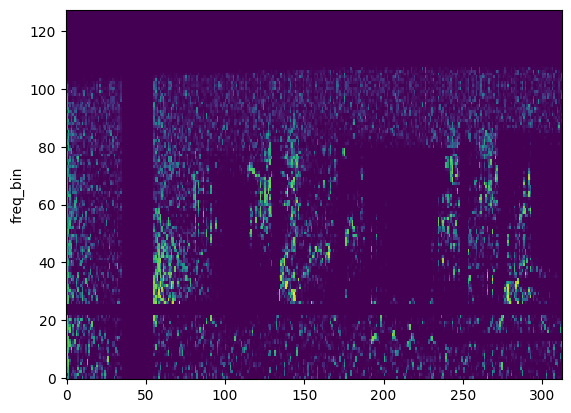

In [ ]:
ds = get_dataset('test_base_pcn_aug_rnd')
ds.metadata
data = ds.__getitem__(0)
mel = data['input']
plot_spectrogram(mel[0], db=True)

In [ ]:
#| export


def get_dataloader(dataset_key:str,            # The key to access the dataset
                dataloader_kwargs:dict={}      # The optional parameters for a pytorch dataloader
                )->DataLoader:              # Pytorch dataloader
    "A function to get a dataloader from a specific dataset"
    dataset = get_dataset(dataset_key)
    

    return DataLoader(dataset, **dataloader_kwargs, )

An example of getting a dataloader

In [ ]:
#| eval:false
dl = get_dataloader('test_base', {'batch_size': 12})
for batch in dl:
    print(batch['input'].shape)
    break

c:\Users\matte\Desktop\birdclef_2023\.venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


LibsndfileError: Error opening '../data/audio_data/hoopoe/XC402638.ogg': System error.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()